## データ読み込み

In [4]:
import pandas as pd

# 保存先のCSVファイル名
csv_filename = "USGS Earthquake Data.csv"

df = pd.read_csv(csv_filename)
print("読み込んだデータ数:", len(df))
print(df.info())

読み込んだデータ数: 1046420
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046420 entries, 0 to 1046419
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   time             1046420 non-null  object 
 1   latitude         1046420 non-null  float64
 2   longitude        1046420 non-null  float64
 3   depth            1045694 non-null  float64
 4   mag              999391 non-null   float64
 5   magType          999202 non-null   object 
 6   nst              853403 non-null   float64
 7   gap              858037 non-null   float64
 8   dmin             652210 non-null   float64
 9   rms              1024097 non-null  float64
 10  net              1046420 non-null  object 
 11  id               1046420 non-null  object 
 12  updated          1046420 non-null  object 
 13  place            1046420 non-null  object 
 14  type             1046420 non-null  object 
 15  horizontalError  668358 non-null   float64
 16 

## データの前処理

前処理後のNull
time                   0
latitude               0
longitude              0
magType                0
net                    0
id                     0
updated                0
place                  0
type                   0
status                 0
locationSource         0
magSource              0
year                   0
mag_log                0
depth_log              0
nst_log                0
gap_log                0
dmin_log               0
rms_log                0
horizontalError_log    0
depthError_log         0
magError_log           0
magNst_log             0
dtype: int64
データ形式: (1006947, 23)


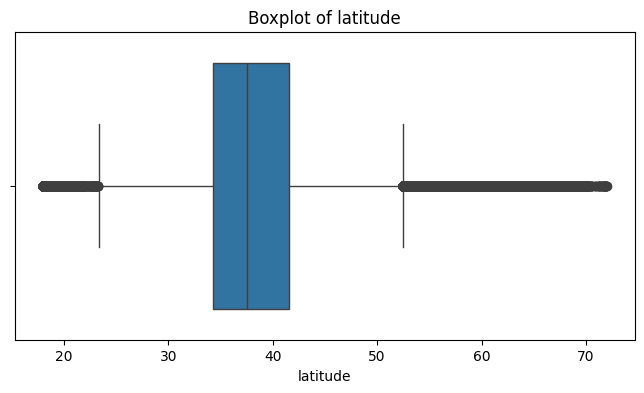

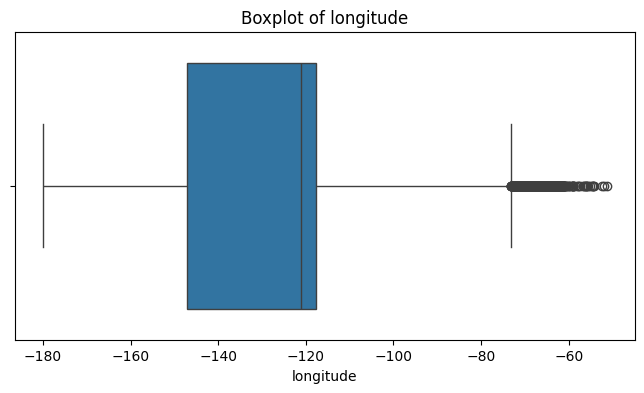

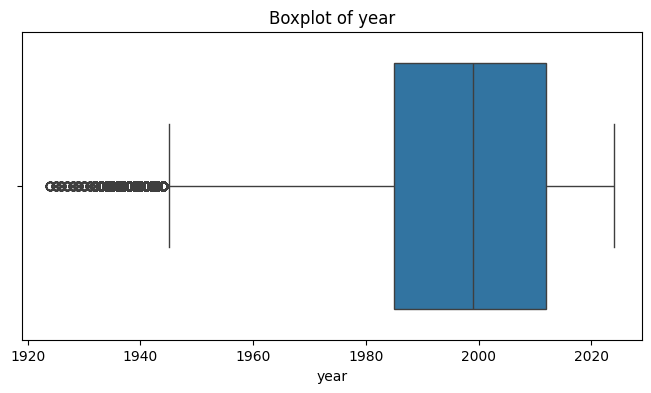

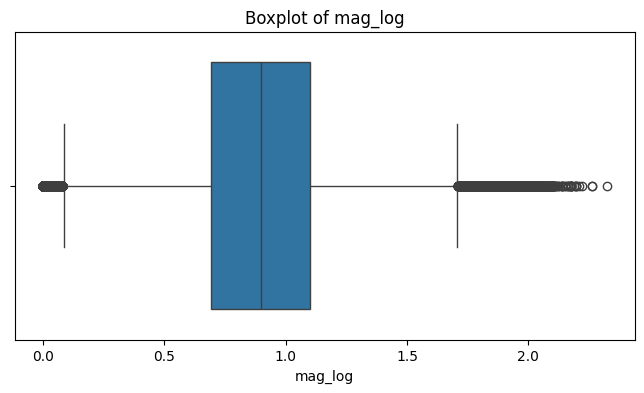

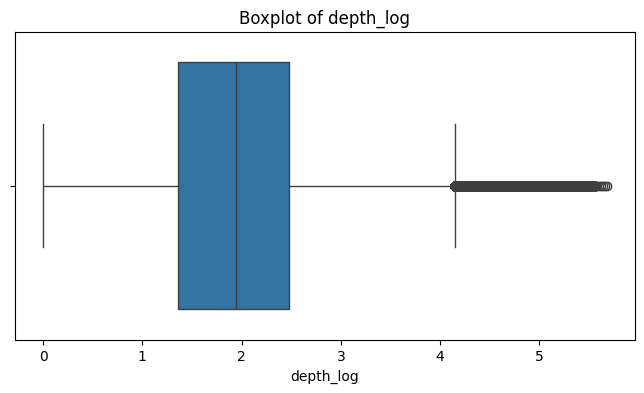

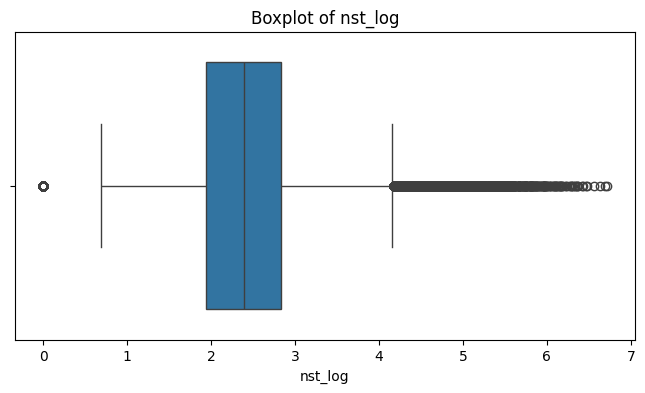

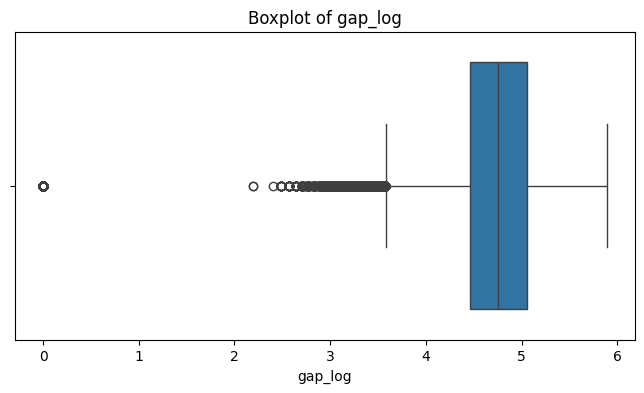

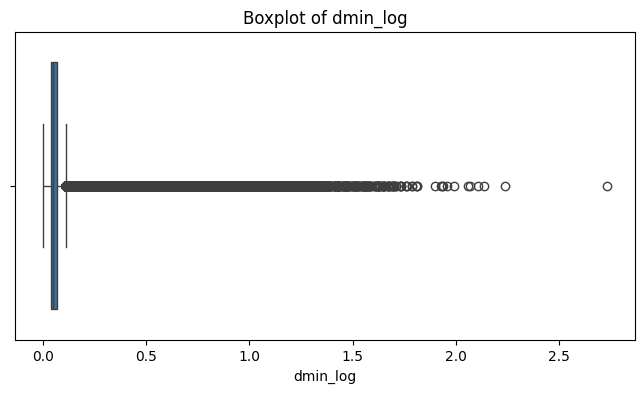

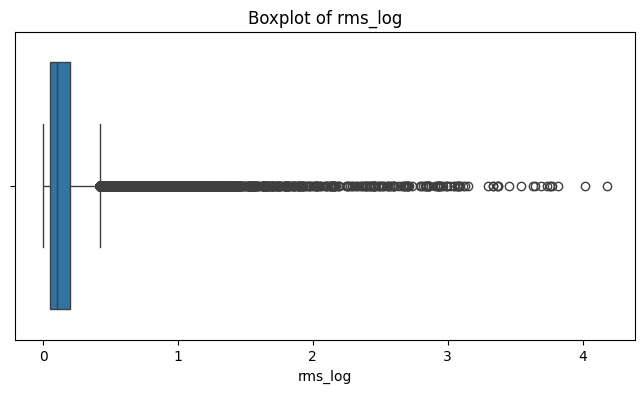

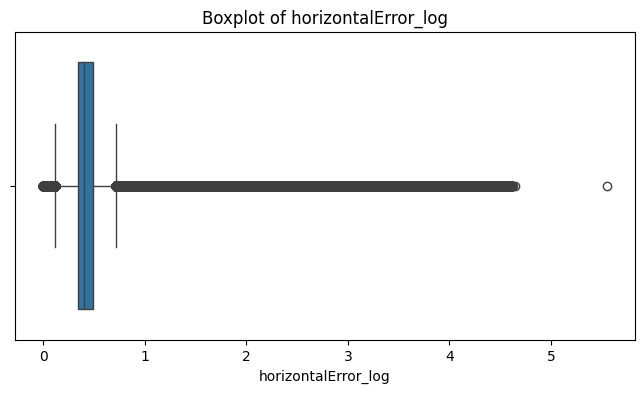

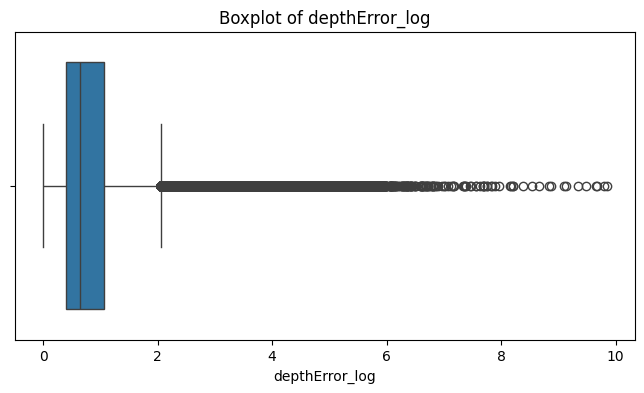

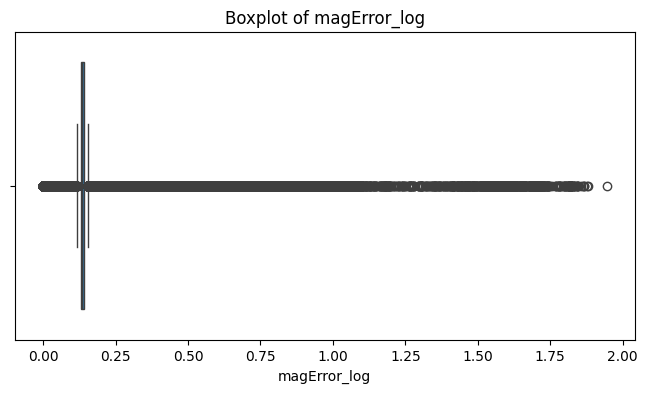

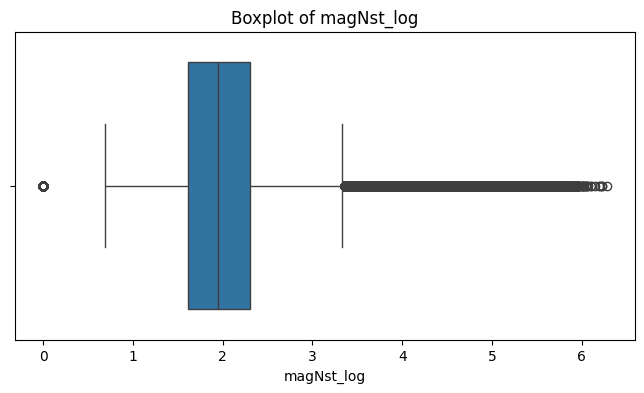

           latitude     longitude          year       mag_log     depth_log  \
count  1.006947e+06  1.006947e+06  1.006947e+06  1.006947e+06  1.006947e+06   
mean   3.964132e+01 -1.279307e+02  1.997901e+03  8.827341e-01  1.974897e+00   
std    1.182937e+01  1.782394e+01  1.653622e+01  3.298892e-01  1.042099e+00   
min    1.800000e+01 -1.799983e+02  1.924000e+03  0.000000e+00  0.000000e+00   
25%    3.424850e+01 -1.472376e+02  1.985000e+03  6.931472e-01  1.355835e+00   
50%    3.752217e+01 -1.211758e+02  1.999000e+03  8.960880e-01  1.945910e+00   
75%    4.153517e+01 -1.176210e+02  2.012000e+03  1.098612e+00  2.472834e+00   
max    7.198400e+01 -5.133300e+01  2.024000e+03  2.322388e+00  5.677096e+00   

            nst_log       gap_log      dmin_log       rms_log  \
count  1.006947e+06  1.006947e+06  1.006947e+06  1.006947e+06   
mean   2.248443e+00  4.748948e+00  7.916839e-02  1.594121e-01   
std    9.993033e-01  5.427416e-01  1.163095e-01  1.585344e-01   
min    0.000000e+00  0.00000

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. データのフィルタリング
df = df[df['type'] == 'earthquake'].copy()  # "earthquake" のみ

df['time'] = pd.to_datetime(df['time'], errors='coerce') # 日付時刻形式
df['year'] = df['time'].dt.year #yearを抽出


# lat_bin, lon_bin, id の削除
# df.drop(columns=['lat_bin','lon_bin','id'], inplace=True, errors='ignore')


# 2. 数値カラムの欠損値を中央値で補完
# 必要な数値カラムの一覧を作り、全ての欠損を各々の中央値で埋める。
num_cols_to_fill = [
    'nst', 'gap', 'dmin', 'magNst',
    'horizontalError', 'depthError', 'magError',
    'rms', 'mag', 'depth'
]
for col in num_cols_to_fill:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# 文字列カラム magType は fillna('unobserved') で埋める
df['magType'] = df['magType'].fillna('unobserved')


# 3. 数値カラムのログ変換 → 元カラムを削除
# ログ変換するカラムのリストを定義
cols_to_log = [
    'mag', 'depth', 'nst', 'gap', 'dmin', 'rms',
    'horizontalError', 'depthError', 'magError', 'magNst'
]

for col in cols_to_log:
    if col in df.columns:
        # 負値をクリップして0に
        df[col+'_log'] = np.log1p(df[col].clip(lower=0))
        # ログ変換後、元のカラムは削除
        df.drop(columns=[col], inplace=True)


# 4. 残りの欠損値を除外 or 補完
# ログ列全てを fillna(0) する
log_cols = [c for c in df.columns if c.endswith('_log')]
df[log_cols] = df[log_cols].fillna(0)

# 全カラム対象に、最終的にNaNがある行は除外
df.dropna(axis=0, how='any', inplace=True)


# 5. 確認
print("前処理後のNull")
print(df.isnull().sum())

print("データ形式:", df.shape)

# 外れ値の確認 (数値カラムの箱ひげ図)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

# 統計量
print(df[numeric_cols].describe())


## 特微量エンジニアリング

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


# モーメントマグニチュード (Mw) のデータのみを使用
df_fe = df.copy()
df_fe = df_fe[df_fe['magType'].str.lower() == 'mw'].copy()  # 大文字小文字を無視

# 時間に関する特徴量の作成
# 時間を細分化
df_fe['year']  = df_fe['time'].dt.year
df_fe['month'] = df_fe['time'].dt.month
df_fe['day']   = df_fe['time'].dt.day
df_fe['hour']  = df_fe['time'].dt.hour
df_fe['weekday'] = df_fe['time'].dt.weekday

# 月や時刻の周期性を捉えるためにサイン・コサイン変換
df_fe['month_sin'] = np.sin(2 * np.pi * df_fe['month'] / 12)
df_fe['month_cos'] = np.cos(2 * np.pi * df_fe['month'] / 12)
df_fe['hour_sin']  = np.sin(2 * np.pi * df_fe['hour'] / 24)
df_fe['hour_cos']  = np.cos(2 * np.pi * df_fe['hour'] / 24)

# 緯度・軽度の平均値からの距離を新しい特微量にする
center_lat = df_fe['latitude'].mean()
center_lon = df_fe['longitude'].mean()
df_fe['distance_from_center'] = np.sqrt(
    (df_fe['latitude'] - center_lat) ** 2 + 
    (df_fe['longitude'] - center_lon)**2
)

# カテゴリ変数の数値化 (One-Hot Encoding) 
# 'nst', 'gap', 'dmin', 'magNst' は除外 → Embedding で使用

# オブジェクト型とカテゴリ型のカラムを抽出
categorical_cols = df_fe.select_dtypes(include=['object', 'category']).columns.tolist()

# 除外カラム（時系列の固有IDなど）や Embedding 予定のカテゴリ
exclude_cols = ['time', 'updated', 'place',   # 元の例
                'nst', 'gap', 'dmin', 'magNst']  # Embedding で使用するカラム

categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# One-Hot Encoding の実施
df_fe = pd.get_dummies(df_fe, columns=categorical_cols, drop_first=True)

print("One-Hot Encoding 後の df_fe の形状:", df_fe.shape)
print("One-Hot Encoding 後の先頭5行:")
print(df_fe.head())
print(df_fe.info())
print(df_fe.dtypes)

One-Hot Encoding 後の df_fe の形状: (2076, 2164)
One-Hot Encoding 後の先頭5行:
                              time  latitude  longitude  \
3 1924-08-21 18:50:54.600000+00:00    50.875   -179.263   
5 1924-08-14 00:45:40.860000+00:00    53.104   -163.213   
6 1924-08-13 13:30:27.130000+00:00    51.629   -178.063   
7 1924-05-06 10:32:13.410000+00:00    54.589   -160.747   
8 1924-04-21 20:00:59.140000+00:00    18.632   -100.802   

                    updated                           place  year   mag_log  \
3  2022-04-25T23:32:29.963Z      214 km WSW of Adak, Alaska  1924  1.968510   
5  2022-04-25T23:32:13.978Z  195 km S of False Pass, Alaska  1924  1.951608   
6  2022-04-25T23:32:06.896Z      102 km WSW of Adak, Alaska  1924  1.972691   
7  2022-04-25T23:30:55.402Z   84 km S of Sand Point, Alaska  1924  1.893112   
8  2022-04-25T23:30:43.073Z   4 km NNW of San Lucas, Mexico  1924  1.996060   

   depth_log   nst_log  gap_log  ...  magSource_official  magSource_par  \
3   3.583519  2.397895  4.

## モデル作成

### ライブラリのインポート

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import optuna



#### データの前処理

In [13]:
# ターゲットを'depth_log' に設定
target_column = 'depth_log'
X = df_fe.drop(columns=[target_column])
y = df_fe[target_column]

# 数値型カラムのみ抽出
X = X.select_dtypes(include=[np.number])


# 学習用・テスト用に分割 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徴量の標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Tensorに変換
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

### 線形回帰

In [15]:
# 線形回帰モデルの定義
input_size = X_train_tensor.shape[1]
model = nn.Linear(input_size, 1)

# 損失関数とオプティマイザの定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 学習ループ
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# テストセットでの評価
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).detach().numpy()
    y_test_np = y_test_tensor.numpy()

mse = mean_squared_error(y_test_np, predictions)
mae = mean_absolute_error(y_test_np, predictions)
r2 = r2_score(y_test_np, predictions)

print("\nEvaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# 特徴量重要度の出力
# 線形回帰モデルの場合、各特徴量に対応する重みがそのまま重要度として解釈可能
feature_importance = model.weight.detach().numpy().flatten()
features = X_train.columns

feature_importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance})
feature_importance_df['abs_importance'] = feature_importance_df['importance'].abs()
feature_importance_df.sort_values(by='abs_importance', ascending=False, inplace=True)

print("\nFeature Importances:")
print(feature_importance_df[['feature', 'importance']])


Epoch [20/200], Loss: 8.4305
Epoch [40/200], Loss: 7.3076
Epoch [60/200], Loss: 6.3374
Epoch [80/200], Loss: 5.4793
Epoch [100/200], Loss: 4.7219
Epoch [120/200], Loss: 4.0566
Epoch [140/200], Loss: 3.4755
Epoch [160/200], Loss: 2.9709
Epoch [180/200], Loss: 2.5355
Epoch [200/200], Loss: 2.1622

Evaluation Metrics:
MSE: 2.0735
MAE: 1.3262
R2 Score: -1.9995

Feature Importances:
                 feature  importance
1              longitude   -0.311782
3                mag_log    0.210744
6               dmin_log   -0.176750
20  distance_from_center    0.152021
2                   year    0.135903
4                nst_log   -0.099572
5                gap_log    0.088261
18              hour_sin   -0.055953
10          magError_log    0.054716
9         depthError_log    0.053258
14                  hour   -0.044876
7                rms_log    0.037720
19              hour_cos    0.023405
12                 month    0.022511
0               latitude   -0.021814
8    horizontalError_log   

### ランダムフォレスト

In [17]:

# Random Forestモデルの定義
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# テストセットでの予測
y_pred = rf_model.predict(X_test)

# 評価指標の算出
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("\nRandom Forest Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# 特徴量重要度の出力
importances = rf_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

print("\nFeature Importances:")
print(feature_importance_df)


Random Forest Evaluation Metrics:
MSE: 0.2122
MAE: 0.2958
R2 Score: 0.6930

Feature Importances:
                 feature  importance
1              longitude    0.359173
3                mag_log    0.172878
0               latitude    0.101356
20  distance_from_center    0.099221
9         depthError_log    0.046148
6               dmin_log    0.045417
2                   year    0.041290
10          magError_log    0.018302
13                   day    0.014262
8    horizontalError_log    0.012755
4                nst_log    0.012082
7                rms_log    0.011727
19              hour_cos    0.010503
15               weekday    0.010027
14                  hour    0.009280
5                gap_log    0.008920
18              hour_sin    0.008155
12                 month    0.005165
16             month_sin    0.004917
17             month_cos    0.004634
11            magNst_log    0.003789


### ニューラルネットワーク

Epoch [100/3000], Loss: 0.9033
Epoch [200/3000], Loss: 0.6001
Epoch [300/3000], Loss: 0.4346
Epoch [400/3000], Loss: 0.3734
Epoch [500/3000], Loss: 0.2868
Epoch [600/3000], Loss: 0.2455
Epoch [700/3000], Loss: 0.2143
Epoch [800/3000], Loss: 0.1920
Epoch [900/3000], Loss: 0.1840
Epoch [1000/3000], Loss: 0.1722
Epoch [1100/3000], Loss: 0.1662
Epoch [1200/3000], Loss: 0.1694
Epoch [1300/3000], Loss: 0.1570
Epoch [1400/3000], Loss: 0.1518
Epoch [1500/3000], Loss: 0.1403
Epoch [1600/3000], Loss: 0.1419
Epoch [1700/3000], Loss: 0.1420
Epoch [1800/3000], Loss: 0.1423
Epoch [1900/3000], Loss: 0.1464
Epoch [2000/3000], Loss: 0.1344
Epoch [2100/3000], Loss: 0.1322
Epoch [2200/3000], Loss: 0.1314
Epoch [2300/3000], Loss: 0.1441
Epoch [2400/3000], Loss: 0.1244
Epoch [2500/3000], Loss: 0.1197
Epoch [2600/3000], Loss: 0.1315
Epoch [2700/3000], Loss: 0.1482
Epoch [2800/3000], Loss: 0.1430
Epoch [2900/3000], Loss: 0.1395
Epoch [3000/3000], Loss: 0.1423

Deep Neural Network Plus Evaluation Metrics:
MSE

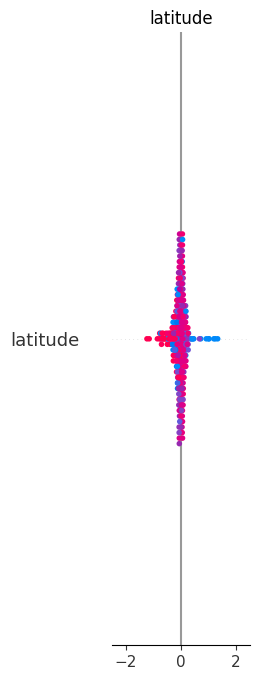

In [19]:
# ニューラルネットワークの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        
        # 全結合層の定義
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)
        
        # 活性化関数の定義(ReLU)
        self.relu = nn.ReLU()
        
        # ドロップアウト層の定義
        self.dropout = nn.Dropout(p=0.2)  # ドロップアウト率 20%
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.dropout(self.relu(self.fc6(x)))
        x = self.fc7(x) # 出力層
        return x

# 入力データの次元数を取得してニューラルネットワークの入力サイズに指定
input_size = X_train_tensor.shape[1]

#モデルをインスタンス化
model = NeuralNetwork(input_size)

# MSEを損失関数として使用
criterion = nn.MSELoss()

# Adam オプティマイザの設定
optimizer = optim.Adam(model.parameters(), lr=0.01)  # 学習率を0.01に設定

# 学習ループ
num_epochs = 3000  #エポック数
for epoch in range(num_epochs):
    model.train()            # モデルを訓練モードに切替
    optimizer.zero_grad()    # 勾配の初期化（前回の勾配情報をクリア）
    # 順伝播：訓練データをモデルに入力して出力を取得
    outputs = model(X_train_tensor)
    # 損失の計算：出力と正解ラベルの間のMSEを算出
    loss = criterion(outputs, y_train_tensor)
    # 逆伝播：勾配の計算
    loss.backward()
    # パラメータの更新
    optimizer.step()

    # 50エポックごとに現在のエポック数と損失値を表示
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# テストデータでの評価
model.eval() # 評価モードに切替

with torch.no_grad():
    # 予測値を取得
    predictions = model(X_test_tensor).detach().numpy()
    # 正解ラベルをNumPy配列に変換
    y_test_np = y_test_tensor.numpy()

# 評価指標の計算
# 平均二乗誤差（MSE）、平均絶対誤差（MAE）、決定係数（R2）を算出
mse = mean_squared_error(y_test_np, predictions)
mae = mean_absolute_error(y_test_np, predictions)
r2 = r2_score(y_test_np, predictions)

# 結果を出力
print("\nDeep Neural Network Plus Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# SHAP を用いた特徴量重要度の評価
background = X_train_tensor[:100]
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(X_test_tensor)
# SHAP の summary plot を表示
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


### XGBoost

In [21]:
# ハイパーパラメータ探索用の評価関数
def xgb_evaluate(max_depth, learning_rate, subsample, colsample_bytree):
    
    # max_depthは整数に変換する必要があるためキャスト
    max_depth = int(max_depth)
    
    # XGBoostモデルの定義（他のパラメータは最適化対象）
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )
    
    # 学習
    model.fit(X_train, y_train)
    # テストセットで予測
    y_pred = model.predict(X_test)
    # MSEを計算
    mse = mean_squared_error(y_test, y_pred)
    # BayesianOptimizationは最大化を目的とするので、-MSEを返す
    return -mse

# 探索するハイパーパラメータの範囲を設定
param_bounds = {
    'max_depth': (0, 100),           # max_depthの範囲（整数）
    'learning_rate': (0.001, 0.5),     # 学習率の範囲
    'subsample': (0.5, 1.0),          # subsample比率の範囲
    'colsample_bytree': (0.5, 1.0)    # colsample_bytreeの範囲
}

# Bayesian Optimizationの実行
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# init_point: 初期点
# n_iter: 試行回数
optimizer.maximize(init_points=5, n_iter=50)

# 最適なハイパーパラメータの取得
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])  # max_depthは整数にキャスト
print("Best parameters found:", best_params)

# 最適なハイパーパラメータを用いて最終モデルを学習
best_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)
best_model.fit(X_train, y_train)

# テストセットでの予測と評価指標の算出
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

# 結果の出力
print("\nXGBoost Evaluation Metrics with Bayesian Optimization:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# 特徴量重要度の出力
importances = best_model.feature_importances_
features = X.columns  # Xは特徴量のDataFrame
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

print("\nFeature Importances:")
print(feature_importance_df)


|   iter    |  target   | colsam... | learni... | max_depth | subsample |
-------------------------------------------------------------------------
| 1         | -0.2171   | 0.6873    | 0.4754    | 73.2      | 0.7993    |
| 2         | -0.1917   | 0.578     | 0.07884   | 5.808     | 0.9331    |
| 3         | -0.2189   | 0.8006    | 0.3543    | 2.058     | 0.985     |
| 4         | -0.1985   | 0.9162    | 0.107     | 18.18     | 0.5917    |
| 5         | -0.2037   | 0.6521    | 0.2629    | 43.19     | 0.6456    |
| 6         | -0.1969   | 0.537     | 0.1189    | 5.77      | 0.8093    |
| 7         | -0.2009   | 0.5687    | 0.1106    | 5.745     | 0.8824    |
| 8         | -0.1819   | 0.5022    | 0.02114   | 46.65     | 0.6761    |
| 9         | -0.2096   | 0.6789    | 0.1168    | 5.928     | 0.9897    |
| 10        | -0.1879   | 0.5062    | 0.03734   | 46.69     | 0.7846    |
| 11        | -0.204    | 0.9692    | 0.3535    | 45.01     | 0.9992    |
| 12        | -0.2323   | 0.8876    | 

### XGBoostとRamdomForest
### 最終推定器：LinearRegression

In [23]:
# ハイパーパラメータ探索用の評価関数：RandomForest
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    """
    RandomForestのハイパーパラメータ探索用評価関数
    - 与えられたパラメータでモデルを構築し、トレーニングデータで学習後、
      テストデータでのMSEを算出する。
    - BayesianOptimization等で最大化を目的とするため、-MSEを返す。
    """
    # パラメータを整数にキャスト
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # RandomForestモデルの定義
    model = RandomForestRegressor(
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    # モデルの学習
    model.fit(X_train, y_train)
    
    # テストセットでの予測
    y_pred = model.predict(X_test)
    
    # MSEを計算
    mse = mean_squared_error(y_test, y_pred)
    
    # 最大化を目的とするため、-MSEを返す
    return -mse

# ハイパーパラメータ探索用の評価関数：XGBoost
def xgb_evaluate(trial):
    """
    XGBoostのハイパーパラメータ探索用評価関数
    - trialからサジェストされたパラメータを用いてモデルを構築し、学習後、
      テストセットでのMSEを算出する。
    - BayesianOptimization等で最大化を目的とするため、-MSEを返す。
    """
    # ハイパーパラメータのサジェストとキャスト
    n_estimators = int(trial.suggest_int("n_estimators", 50, 300))
    max_depth = int(trial.suggest_int("max_depth", 3, 15))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    
    # XGBoostモデルの定義
    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # モデルの学習
    model.fit(X_train, y_train)
    
    # テストセットでの予測
    y_pred = model.predict(X_test)
    
    # MSEを計算
    mse = mean_squared_error(y_test, y_pred)
    
    # 最大化を目的とするため、-MSEを返す
    return -mse

# 3. Optunaによるハイパーパラメータ探索：RandomForest
# studyのdirectionを"maximize"に設定（-MSEを最大化するため）
study_rf = optuna.create_study(direction="maximize")

# lambda関数を用いて、rf_evaluateに各ハイパーパラメータのサジェスト値を渡して評価
study_rf.optimize(lambda trial: rf_evaluate(
    trial.suggest_int("n_estimators", 50, 300),
    trial.suggest_int("max_depth", 5, 30),
    trial.suggest_int("min_samples_split", 2, 10),
    trial.suggest_int("min_samples_leaf", 1, 5)
), n_trials=50)
print("Best RandomForest Params:", study_rf.best_trial.params)

# 最適なハイパーパラメータでRandomForestを学習
best_rf = RandomForestRegressor(random_state=42, **study_rf.best_trial.params)
best_rf.fit(X_train, y_train)

# Optunaによるハイパーパラメータ探索：XGBoost
study_xgb = optuna.create_study(direction="maximize")

# xgb_evaluate関数を使用してXGBoostのハイパーパラメータ探索を実施
study_xgb.optimize(xgb_evaluate, n_trials=50)
print("Best XGB Params:", study_xgb.best_trial.params)

# 最適なハイパーパラメータでXGBoostを学習
best_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, **study_xgb.best_trial.params)
best_xgb.fit(X_train, y_train)

# 5. 各モデルの評価関数
def evaluate_model(name, model, X_test, y_test):
    """
    指定されたモデルの性能を評価する関数
    - テストセットでの予測を行い、MSE、MAE、R2スコアを算出して表示する。
    """
    # テストデータでの予測
    y_pred = model.predict(X_test)
    # 平均二乗誤差（MSE）の算出
    mse = mean_squared_error(y_test, y_pred)
    # 平均絶対誤差（MAE）の算出
    mae = mean_absolute_error(y_test, y_pred)
    # 決定係数（R2）の算出
    r2 = r2_score(y_test, y_pred)
    # 結果の表示
    print(f"\n{name} Evaluation Metrics:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}")

# 各最適化済みモデルの評価を実施
evaluate_model("RandomForest", best_rf, X_test, y_test)
evaluate_model("XGBoost", best_xgb, X_test, y_test)

# 6. Weighted Voting
# VotingRegressorでRandomForestとXGBoostを組み合わせ、各モデルに重みを付与
voting_reg = VotingRegressor(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    weights=[0.4, 0.6] # XGBoostをやや重視する
)
# VotingRegressorの学習
voting_reg.fit(X_train, y_train)
# アンサンブルモデルの評価
evaluate_model("WeightedVoting(RF+XGB)", voting_reg, X_test, y_test)

# 7. StackingRegressor
# StackingRegressorは複数のベースモデルの予測結果と元の特徴量を用いて、最終的な予測を行うメタモデルを学習する
# ここでは、最終推定器として線形回帰（LinearRegression）を用い、passthrough=Trueにより元の特徴量もメタモデルへ入力する設定
stacking_reg = StackingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    final_estimator=LinearRegression(),
    passthrough=True
)

# StackingRegressorの学習
stacking_reg.fit(X_train, y_train)
# アンサンブルモデルの評価
evaluate_model("StackingRegressor(LinearRegression, passthrough=True)", stacking_reg, X_test, y_test)

[I 2025-03-13 08:27:37,070] A new study created in memory with name: no-name-c7b83953-8082-4405-be36-f9bde92f2e25
[I 2025-03-13 08:27:37,587] Trial 0 finished with value: -0.21843910704795264 and parameters: {'n_estimators': 79, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: -0.21843910704795264.
[I 2025-03-13 08:27:38,994] Trial 1 finished with value: -0.2216572161919288 and parameters: {'n_estimators': 253, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: -0.21843910704795264.
[I 2025-03-13 08:27:39,919] Trial 2 finished with value: -0.21775262147492808 and parameters: {'n_estimators': 143, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: -0.21775262147492808.
[I 2025-03-13 08:27:41,582] Trial 3 finished with value: -0.21328079969137087 and parameters: {'n_estimators': 230, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 

Best RandomForest Params: {'n_estimators': 56, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}


[I 2025-03-13 08:28:21,924] A new study created in memory with name: no-name-57af9fe2-d9d9-4d95-8a19-6e20fb3be15d
[I 2025-03-13 08:28:22,217] Trial 0 finished with value: -0.18765643375214908 and parameters: {'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.033427698248061605, 'subsample': 0.9425848047752722, 'colsample_bytree': 0.789091385024149}. Best is trial 0 with value: -0.18765643375214908.
[I 2025-03-13 08:28:22,857] Trial 1 finished with value: -0.19482477281354724 and parameters: {'n_estimators': 285, 'max_depth': 8, 'learning_rate': 0.14149685182592764, 'subsample': 0.6086178014604087, 'colsample_bytree': 0.7781754437936805}. Best is trial 0 with value: -0.18765643375214908.
[I 2025-03-13 08:28:23,038] Trial 2 finished with value: -0.21077856311048923 and parameters: {'n_estimators': 179, 'max_depth': 4, 'learning_rate': 0.048048994453346365, 'subsample': 0.8322754997393181, 'colsample_bytree': 0.7081885332012388}. Best is trial 0 with value: -0.18765643375214908.
[I 

Best XGB Params: {'n_estimators': 181, 'max_depth': 12, 'learning_rate': 0.023323470945179576, 'subsample': 0.6917068140019742, 'colsample_bytree': 0.6268213951485491}

RandomForest Evaluation Metrics:
MSE: 0.2059, MAE: 0.2888, R2 Score: 0.7021

XGBoost Evaluation Metrics:
MSE: 0.1755, MAE: 0.2762, R2 Score: 0.7462

WeightedVoting(RF+XGB) Evaluation Metrics:
MSE: 0.1816, MAE: 0.2781, R2 Score: 0.7373

StackingRegressor(LinearRegression, passthrough=True) Evaluation Metrics:
MSE: 0.1738, MAE: 0.2726, R2 Score: 0.7486


### XGBoostとニューラルネットワーク

In [25]:
# PyTorch ニューラルネットワークの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        
        # 全結合層の定義
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)
        
        # 活性化関数の定義(ReLU)
        self.relu = nn.ReLU()
        
        # ドロップアウト層の定義
        self.dropout = nn.Dropout(p=0.2)  # ドロップアウト率 20%
        
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.dropout(self.relu(self.fc6(x)))
        x = self.fc7(x) # 出力層
        return x

# scikit-learn ラッパーの作成
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, lr=0.005, num_epochs=200, batch_size=32, verbose=0):
        """
        TorchRegressor の初期化
        - input_size: 入力次元数（特徴量の数）
        - lr: 学習率
        - num_epochs: エポック数（学習の反復回数）
        - batch_size: バッチサイズ（ミニバッチ学習時のサンプル数）
        - verbose: 学習中のログ出力の有無（0なら出力なし、1なら定期的に出力）
        """
        self.input_size = input_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.verbose = verbose
        # 初期状態のモデルを生成
        self.model_ = NeuralNetwork(input_size)
    
    def fit(self, X, y):
        """
        モデルの学習処理
        - X: 入力特徴量（NumPy配列）
        - y: 目的変数（pandas SeriesまたはNumPy配列）
        """
        # Tensorに変換
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        
        # yがpandas Seriesの場合は.valuesでNumPy配列に変換、そうでなければそのまま使用
        y_array = y.values if hasattr(y, "values") else y
        y_tensor = torch.tensor(y_array, dtype=torch.float32).view(-1, 1)
        
        # 毎回新規にモデルのインスタンスを生成
        self.model_ = NeuralNetwork(self.input_size)
        criterion = nn.MSELoss()  # 損失関数としてMSEを使用
        optimizer = optim.Adam(self.model_.parameters(), lr=self.lr)  # Adamオプティマイザ
        
        # 学習用データセットとDataLoaderの作成
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # 学習モードに設定してエポック単位で学習
        self.model_.train()
        for epoch in range(self.num_epochs):
            for batch_X, batch_y in loader:
                optimizer.zero_grad()              # 勾配の初期化
                outputs = self.model_(batch_X)       # 順伝播で予測値を算出
                loss = criterion(outputs, batch_y)   # 損失を計算
                loss.backward()                      # 逆伝播で勾配計算
                optimizer.step()                     # パラメータの更新
            # verboseが有効な場合、10エポックごとに損失を表示
            if self.verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {loss.item():.4f}")
        return self
    
    def predict(self, X):
        """
        モデルの予測処理
        - 学習済みモデルを用いて入力Xの予測を実施
        """
        self.model_.eval()  # 評価モードに切り替え（ドロップアウトなどが無効）
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        with torch.no_grad():  # 勾配計算を無効化して予測
            predictions = self.model_(X_tensor).numpy().flatten()
        return predictions

# ハイパーパラメータ探索用の評価関数：XGBoost
def xgb_evaluate(trial):
    """
    XGBoostのハイパーパラメータ探索用評価関数
    - trialからサジェストされたパラメータを用いてモデルを構築し、学習後、
      テストセットでのMSEを算出する。
    - BayesianOptimization等で最大化を目的とするため、-MSEを返す。
    """
    # ハイパーパラメータのサジェストとキャスト
    n_estimators = int(trial.suggest_int("n_estimators", 50, 300))
    max_depth = int(trial.suggest_int("max_depth", 3, 15))
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    
    # XGBoostモデルの定義
    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # モデルの学習
    model.fit(X_train, y_train)
    
    # テストセットでの予測
    y_pred = model.predict(X_test)
    
    # MSEを計算
    mse = mean_squared_error(y_test, y_pred)
    
    # 最大化を目的とするため、-MSEを返す
    return -mse

# Optuna の Study を作成し、XGBoost のハイパーパラメータ探索を実行
study = optuna.create_study(direction="minimize")
study.optimize(xgb_evaluate, n_trials=50) # 試行回数は50回
print("Best XGBoost Params:", study.best_trial.params)

# 最適パラメータを用いて XGBoost モデルを再構築・学習
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **study.best_trial.params
)
xgb_model.fit(X_train, y_train)

# ニューラルネットワーク モデルの学習
# 入力サイズはX_trainの列数から取得
input_size = X_train.shape[1]
# TorchRegressorのインスタンス作成（verboseを1に設定して学習状況を表示）
nn_model = TorchRegressor(input_size=input_size, lr=0.005, num_epochs=200, batch_size=32, verbose=1)
nn_model.fit(X_train, y_train)

# 各モデルの評価関数
def evaluate_model(name, model, X_test, y_test):
    """
    指定されたモデルの性能を評価する関数
    - テストデータで予測を実施し、MSE, MAE, R2スコアを計算して表示する。
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{name} Evaluation Metrics:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R2 Score: {r2:.4f}")

# 各モデルの性能評価
evaluate_model("XGBoost", xgb_model, X_test, y_test)
evaluate_model("NeuralNet", nn_model, X_test, y_test)

# XGBoost と ニューラルネットワークのアンサンブル (VotingRegressor)
# VotingRegressor を用いて、XGBoost と TorchRegressor を組み合わせたアンサンブルモデルを構築
# 各モデルの重みは同等（0.5, 0.5）に設定
voting_reg = VotingRegressor(
    estimators=[('xgb', xgb_model), ('nn', nn_model)],
    weights=[0.5, 0.5]
)
voting_reg.fit(X_train, y_train)
evaluate_model("VotingEnsemble (XGB + NeuralNet)", voting_reg, X_test, y_test)


[I 2025-03-13 08:29:00,292] A new study created in memory with name: no-name-9f8550fa-e2a8-4aa2-bbe5-24783cb34d9c
[I 2025-03-13 08:29:00,640] Trial 0 finished with value: -0.18441648302824756 and parameters: {'n_estimators': 112, 'max_depth': 7, 'learning_rate': 0.09205452297475537, 'subsample': 0.8044117335121048, 'colsample_bytree': 0.6803456430210939}. Best is trial 0 with value: -0.18441648302824756.
[I 2025-03-13 08:29:01,317] Trial 1 finished with value: -0.18790318924652522 and parameters: {'n_estimators': 149, 'max_depth': 10, 'learning_rate': 0.1313218707343876, 'subsample': 0.8860683542768938, 'colsample_bytree': 0.8504189350277356}. Best is trial 1 with value: -0.18790318924652522.
[I 2025-03-13 08:29:02,000] Trial 2 finished with value: -0.18171151599586105 and parameters: {'n_estimators': 242, 'max_depth': 9, 'learning_rate': 0.024908127711856357, 'subsample': 0.8624817846742354, 'colsample_bytree': 0.550615197718965}. Best is trial 1 with value: -0.18790318924652522.
[I 2

Best XGBoost Params: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.010345423952785596, 'subsample': 0.6489866166721809, 'colsample_bytree': 0.9952355367191899}
Epoch 10/200, Loss: 0.9327
Epoch 20/200, Loss: 0.8144
Epoch 30/200, Loss: 0.6624
Epoch 40/200, Loss: 0.5732
Epoch 50/200, Loss: 0.6674
Epoch 60/200, Loss: 0.2249
Epoch 70/200, Loss: 0.9823
Epoch 80/200, Loss: 0.5410
Epoch 90/200, Loss: 0.5113
Epoch 100/200, Loss: 0.7935
Epoch 110/200, Loss: 0.6829
Epoch 120/200, Loss: 0.7242
Epoch 130/200, Loss: 0.3754
Epoch 140/200, Loss: 0.4102
Epoch 150/200, Loss: 0.4413
Epoch 160/200, Loss: 0.5864
Epoch 170/200, Loss: 0.9143
Epoch 180/200, Loss: 0.6043
Epoch 190/200, Loss: 0.2955
Epoch 200/200, Loss: 0.9819

XGBoost Evaluation Metrics:
MSE: 0.3847, MAE: 0.4442, R2 Score: 0.4436

NeuralNet Evaluation Metrics:
MSE: 0.6919, MAE: 0.6035, R2 Score: -0.0009
Epoch 10/200, Loss: 1.1466
Epoch 20/200, Loss: 1.0717
Epoch 30/200, Loss: 0.6159
Epoch 40/200, Loss: 0.6427
Epoch 50/200, Loss: 0.5

### AutoMLを使って最適なアルゴリズムを探す

In [27]:
from autogluon.tabular import TabularPredictor

# ターゲット変数の指定
label = 'depth_log'
data = df_fe.copy()
# データを学習用とテスト用に分割
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# AutoGluon を用いた学習を実行
# label: 目的変数のカラム名
# eval_metric: 評価指標として RMSEを使用
predictor = TabularPredictor(label=label, eval_metric='rmse').fit(
    train_data,  # 学習用データセット
    presets='best_quality',  # 高品質な学習を行うための事前定義プリセットを利用
    auto_stack=True,  # モデル間のスタッキング（アンサンブル学習）を有効化
    hyperparameters={
        # 各モデルのハイパーパラメータ設定を辞書形式で指定
        'XGB': {
            'num_boost_round': 200, #  決定木の数を設定
        },
        'CAT': {},      # CatBoost のデフォルト設定を使用
        'GBM': {},      # LightGBM のデフォルト設定を使用
        'RF': {},       # RandomForest のデフォルト設定を使用
        'LR': {},       # 線形回帰モデル（Linear Regression）のデフォルト設定を使用
        'KNN': {},      # k近傍法モデル（K-Nearest Neighbors）のデフォルト設定を使用
        'NN_TORCH': [   # PyTorch を用いたニューラルネットワークの設定
            {'num_epochs': 200},  # エポック数を設定
            {   # カスタム設定: 隠れ層サイズ、ドロップアウト、学習率などを変更
                'num_epochs': 200,
                'ag_args': {'name_suffix': 'custom'},  # モデル名にサフィックスを追加して識別しやすくする
                'layers': [256, 128, 64, 32, 16,8],       # 各層のユニット数を指定
                'dropout_prob': 0.3,                    # ドロップアウト率を設定
                'learning_rate': 0.001                  # 学習率設定
            }
        ],
        'FASTAI': {}  # FastAI を用いたディープラーニングモデルのデフォルト設定
    },
    # ハイパーパラメータチューニングの設定
    # num_trials: 試行回数を設定
    # scheduler: ローカル環境での並列実行を指定
    # searcher: ベイズ最適化（bayes）を探索手法として利用
    hyperparameter_tune_kwargs={'num_trials': 50, 'scheduler': 'local', 'searcher': 'bayes'},
    time_limit=18000,  # 総学習時間の上限（秒単位）
    verbosity=1,       # ログの詳細レベルを設定（数値が大きいほど詳細なログが出力される）
    # アンサンブル学習の設定
    fit_weighted_ensemble=True, # 重み付きアンサンブルを学習して最終モデルに組み込む
    dynamic_stacking=True, # 動的なスタッキング戦略を有効化
    raise_on_no_models_fitted=False # 学習可能なモデルが1つも見つからなかった場合に例外を発生させない
)

# テストデータで評価
# 学習済みのモデルを用いて、テストデータに対する評価を実施
results = predictor.evaluate(test_data)
print(results)


2025-03-13 09:56:40,733	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/suzukishouta/開発/AI/practice/Earthquake/AutogluonModels/ag-20250313_132940/models/NeuralNetFastAI_BAG_L1' in 0.0155s.
2025-03-13 09:56:40,772	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 50 trial(s):
- 5910a7bf: FileNotFoundError('Could not fetch metrics for 5910a7bf: both result.json and progress.csv were not found at /Users/suzukishouta/開発/AI/practice/Earthquake/AutogluonModels/ag-20250313_132940/models/NeuralNetFastAI_BAG_L1/5910a7bf')
- f487e689: FileNotFoundError('Could not fetch metrics for f487e689: both result.json and progress.csv were not found at /Users/suzukishouta/開発/AI/practice/Earthquake/AutogluonModels/ag-20250313_132940/models/NeuralNetFastAI_BAG_L1/f487e689')
- d1548acd: FileNotFoundError('Could not fetch metrics for d1548acd: both result.json and progress.csv were not found at /Users/suzukishouta/開発/AI/practice/Earthquake/Autog

  0%|          | 0/50 [00:00<?, ?it/s]

	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 11.06% memory usage per fold, 44.26%/80.00% total).
	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 11.26% memory usage per fold, 45.05%/80.00% total).
	Memory not enough to fit 8 folds in parallel. Will train 1 folds in parallel instead (Estimated 46.38% memory usage per fold, 46.38%/80.00% total).
		Switching to pseudo sequential ParallelFoldFittingStrategy to avoid Python memory leakage.
		Overrule this behavior by setting fold_fitting_strategy to 'sequential_local' in ag_args_ensemble when when calling `predictor.fit`
	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 11.46% memory usage per fold, 45.84%/80.00% total).
	To avoid this warning, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.29 to avoid the warning)
		To set the same valu

  0%|          | 0/50 [00:00<?, ?it/s]

The task's local raylet died. Check raylet.out for more information.
Traceback (most recent call last):
  File "/opt/anaconda3/envs/torch_env/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/opt/anaconda3/envs/torch_env/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/opt/anaconda3/envs/torch_env/lib/python3.10/site-packages/autogluon/core/models/abstract/abstract_model.py", line 925, in fit
    out = self._fit(**kwargs)
  File "/opt/anaconda3/envs/torch_env/lib/python3.10/site-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 270, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "/opt/anaconda3/envs/torch_env/lib/python3.10/site-packages/autogluon/core/models/ensemble/bagged_ensemble_model.py", line 298, in _fit
    self._fi

{'root_mean_squared_error': np.float64(-0.433558895554688), 'mean_squared_error': np.float64(-0.1879733159146009), 'mean_absolute_error': np.float64(-0.2848811041123887), 'r2': 0.728073782129838, 'pearsonr': 0.8538528664816822, 'median_absolute_error': np.float64(-0.1760861078382241)}
(raylet) The node with node id: f242b1d3b907471edc4e1b9645084eb8f0711d89ce83b044ea49d578 and address: 127.0.0.1 and node name: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.


In [55]:
predictor = TabularPredictor.load("AutogluonModels/ag-20250313_132940")
leaderboard = predictor.leaderboard()
print(leaderboard)

                               model  score_val              eval_metric  \
0                WeightedEnsemble_L2  -0.425764  root_mean_squared_error   
1                 XGBoost_BAG_L1/T24  -0.430217  root_mean_squared_error   
2                 XGBoost_BAG_L1/T44  -0.431041  root_mean_squared_error   
3                 XGBoost_BAG_L1/T16  -0.431460  root_mean_squared_error   
4                  XGBoost_BAG_L1/T2  -0.431826  root_mean_squared_error   
..                               ...        ...                      ...   
157  NeuralNetFastAI_BAG_L1/ebcc43bb  -0.716560  root_mean_squared_error   
158                KNeighbors_BAG_L1  -0.722331  root_mean_squared_error   
159  NeuralNetFastAI_BAG_L1/c128898e  -0.744581  root_mean_squared_error   
160  NeuralNetFastAI_BAG_L1/020d8e95  -0.754423  root_mean_squared_error   
161  NeuralNetFastAI_BAG_L1/73dc8450  -0.801300  root_mean_squared_error   

     pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  \
0         

In [73]:
# テストデータで予測
predictions = predictor.predict(test_data)
print(predictions)

# テストデータで評価
results = predictor.evaluate(test_data)
print(results)

5461      3.251751
29181     2.683823
16967     3.187731
3586      2.732303
21975     2.683930
            ...   
22453     3.409798
1313      3.622627
14855     3.289596
453416    2.005873
13564     2.813243
Name: depth_log, Length: 416, dtype: float32
{'root_mean_squared_error': np.float64(-0.433558895554688), 'mean_squared_error': np.float64(-0.1879733159146009), 'mean_absolute_error': np.float64(-0.2848811041123887), 'r2': 0.728073782129838, 'pearsonr': 0.8538528664816822, 'median_absolute_error': np.float64(-0.1760861078382241)}
